# Predicting the Knowledge Level of Students

# Introduction

<table><tr>
<td> <img src="https://leverageedublog.s3.ap-south-1.amazonaws.com/blog/wp-content/uploads/2020/03/24185535/Online-Learning.jpg" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="https://blog.edmentum.com/sites/blog.edmentum.com/files/infographics/Four_Layers_0.jpg" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="https://i0.wp.com/content.edupristine.com/images/blogs/CFA-RESULT-2016.jpg?w=525&ssl=1" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

Nowadays, the need to determine students' intelligence effectively and efficiently is critical for various reasons. Whether for a job or a spot in the most prestigious university, we need ways to choose the most prominent candidates among the thousand applicants. 

This prompts us to question: **Can we predict the knowledge levels of students based on specific studying metrics?** If so, what metrics (variables) create the most optimal predictive model? With that motivation in mind, this project aims to develop a k-nearest neighbors machine learning model that can predict the knowledge level of the students based on various metrics. 


The dataset that is used in this project is from https://archive.ics.uci.edu/ml/datasets/User%2BKnowledge%2BModeling. The dataset records the students' knowledge status from Gazi University, Turkey, in 2009. Gazi University has developed a user modeling system that keeps track of students' learning activities on the web learning environment and stores the data in the model. The dataset allows us to observe students' learning experiences on the online learning platform and exam performance. Then the data are used as input data by a user modeling algorithm to create a consistent description of the model of students. Eventually, the input data is used to create and update the user knowledge model.

In our project, we would like to utilize the dataset and classify the knowledge level of users based on the information provided in the dataset. 

The dataset contains six columns and a total of 3 sheets in the excel file (dataset):

STG: degree of study time for goal object materials <br>
SCG: degree of repetition number of users for goal object materials <br>
STR: degree of study time of the user for related objects with goal object <br>
LPR: exam performance of the user for related objects with the goal object <br>
PEG: exam performance of user for goal objects <br>
UNS: the knowledge level of user <br>

## Methods & Results
### Overview of our Methodology 

The User Knowledge Modeling dataset provided us with three different datasets **Information** , **Training_set** and **Test_set**. Therefore, our team decided to combine the three sets of data into a single useful dataset that contains all the required data to build our model. Here is an overview of our data analysis methodology (a detailed explanation will be presented at each step):

1. **Reading & Wrangling**: read and wrangle the three excel sheets into one tidy combined dataset. <br>

2. **Train/Test split**: splitting the tidy dataframe into a training set and testing set, then summarizing the sample statistics of the training data.<br>

3. **Predictor variables selection**: find the combination of predictors that yield the relatively highest prediction accuracy using forward selection. <br>

4. **K-Nearest Neighbor classification**: model tuning with cross-validation, reconfiguring and re-train the model with the best K parameter, predict the test set for final model accuracy validation.

5. **Results and Conclusion**:  what we learned from building the classifier 


### Loading Relevant Libraries

In [1]:
library(tidyverse) 
library(readxl)
library(tidymodels)
library(GGally)
library(forcats)
library(RColorBrewer)
library(repr) 
library(ggplot2)
library(knitr)
options(repr.matrix.max.rows = 6) # limits output of dataframes to 6 rows

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## Reading and Wrangling our dataset from the web into R
* We downloaded the file from the web using a URL so that it was reproducible and read the data file
* Due to there being several sheets in a single excel file, we read them separately and merged them into a single dataframe called “User_Knowledge”. 
* The dataset in Sheet 1 (**Information**) has only metadata, so we will ignore this sheet.
* The dataset in Sheet 2 (**Training_Data**) has 1 column of metadata and a total of 258 rows. Therefore `select ()` is used as the argument.
* The dataset in Sheet 3 (**Test_Data**) has 1 column of metadata and a total of 145 rows. Therefore `select ()` is used as the argument.
* There was no missing value in any rows.
* The two given datasets have slightly different UNS subcategories, where the **Training_Data** has categories “*High*,” “*Medium*,” “*Low*,” and “*very_low*,” whereas the **Test_Data** has a “*Very Low*” class instead. Therefore, we change every “*very_low*” to “*Very Low*”.
* We combined the rows of both datasets to form one dataset using `rbind()` because in our proposal submission, we used these two sets as given to us by the dataset and later ran into problems in the analysis.
* The UNS column will be our target variable for this analysis. Therefore, it was converted into a factor variable using `as_factor()`.
* The resulting dataset is our wrangled `User_knowledge` dataset with **403** valuable observations.

In [2]:
#Reading the training data set from the Web into R and cleaning it
user_data_training <- download.file(url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls", destfile = "user_data.xls")
user_data_training <- read_excel("user_data.xls", sheet = 2) # Selecting the "Training_Data"

user_data_training <- select(user_data_training, STG:UNS) #Selecting only the required columns (not including metadata)

user_data_training$UNS[user_data_training$UNS == "very_low"] <- "Very Low" #Setting the "very_low field to Very Low to match with Test_Data"

cat("Table 1.1 : user_data_training")
user_data_training


New names:
• `` -> `...7`
• `` -> `...8`


Table 1.1 : user_data_training

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,Very Low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


In [3]:
#Reading the testing data set from the Web into R and cleaning it
user_data_test <- read_excel("user_data.xls", sheet = 3) #selecting the "Test_Data"
user_data_test <- select(user_data_test, STG:UNS) #Selecting only the required columns (not including metadata)

cat("Table 1.2 : user_data_test")
user_data_test

New names:
• `` -> `...7`
• `` -> `...8`


Table 1.2 : user_data_test

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
⋮,⋮,⋮,⋮,⋮,⋮
0.56,0.60,0.77,0.13,0.32,Low
0.66,0.68,0.81,0.57,0.57,Middle
0.68,0.64,0.79,0.97,0.24,Middle


In [4]:
#Combining both training and test data sets (they have been taken from separate excel sheets)
User_Knowledge <- rbind(user_data_training, user_data_test)|>  #binidng rows in both the data frames using rbind
         mutate(UNS = as_factor(UNS))# mutating UNS column to be of type factor since that column needs to be predicted

cat("Table 1.3: User Knowledge")
User_Knowledge

Table 1.3: User Knowledge

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,Very Low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.56,0.60,0.77,0.13,0.32,Low
0.66,0.68,0.81,0.57,0.57,Middle
0.68,0.64,0.79,0.97,0.24,Middle


## Summarizing the Training Data
* Based on our data wrangling step, we have a total of **403** usable observations.
* Thus, we have done a random split of **0.70**, which means 70% of the data is split into the training set and the remaining 30% into the testing set to ensure that we have an adequate amount of observations for training and evaluating the prediction accuracy of our model.
* We also used `set.seed()` for reproducible results as `initial_split()` randomly samples from the dataframe.

In [5]:
set.seed(1) # Use of set.seed to make the split reproducible
User_Knowledge_split <- initial_split(User_Knowledge, prop = 0.7, strata = UNS) #doing the decided 70-30 split of our combined data set
user_knowledge_training <- training(User_Knowledge_split)
user_knowledge_test <- testing(User_Knowledge_split)

* Now we begin exploratory data analysis by summarizing the data into different types of tables.

In [6]:
#Counting the total number of rows in training data set
training_count <- count(user_knowledge_training) 


#Counting the total number of rows in test data set
test_count <- count(user_knowledge_test) 


<center>Table 1.4 : Number of observations training set</center>

| Number_Of _Observations |
| :-: | 
| 281 |


<center>Table 1.5 : Number of observations testing set</center>

| Number_Of _Observations |
| :-: | 
| 122 |


* The table 1.4 reports that there is **281** observations in **user_knowledge_training** dataset 
* The table 1.5 reports that there is **122** observations in **user_knowledge_test** dataset

In [7]:
#Counting the total number of observations of each class (training data set) to check for class imbalance (if any)
user_data_summarize <- user_knowledge_training |>
                       group_by(UNS) |>
                       summarize(Number_Of_Observations = n())



<center>Table 1.6 : Number of observations per class</center>

| UNS | Number_Of _Observations |
| --- | -: | 
| Very Low |  35|
|  Low |  90|
| Middle |  85|
| High |  71|

* Table 1.6 reports the number of observations in each class.
* Using `group_by(UNS)`, we grouped our table by the UNS variable and then applied `n()` to count the number of observations in each class.
* It is observed that there are fewer cases of *"Very Low"* as compared to the other classes in our training dataset, but there is no need to over-sample the data.


In [8]:
# Using map_df to calculate mean of each of our predictor variables and return the result as a dataframe
user_data_mean <- select(user_knowledge_training, STG:PEG) |>
                  map_df(mean)


<center>Table 1.7 : Mean values of predictors</center>

| STG | SCG | STR | LPR | PEG|
| --- | --- | --- | --- | ---|
| 0.3460427 |  0.3679537| 0.4660676 | 0.4365516|0.4583737|


* Table 1.7 reports the means of the predictor variables.
* Here, we select all the predictor variables and apply `map_df` to apply `mean()` to each of the columns to obtain the mean statistic for each variable.
* The table does not suggest that any specific predictor needs more attention.

In [9]:
# Using map_df to calculate standard deviation of each of our predictor variables and return the result as a dataframe
user_data_sd <- select(user_knowledge_training, STG:PEG) |>
                  map_df(sd)

<center>Table 1.8 : Standard deviations of predictors</center>

| STG | SCG | STR | LPR | PEG|
| --- | --- | --- | --- | ---|
| 0.2125281 |  0.2180526| 0.245591 | 0.2565171|0.2683913|

* Table 1.8 reports the standard deviation of the predictor variables.
* Here, we select all the predictor variables and apply `map_df` to apply `sd()` to each of the columns to obtain the mean statistic for each variable.
* The table does not suggest that any specific predictor needs more attention.

In [10]:
# Using map_df to calculate mean of each of our predictor variables for each class and return the result as a dataframe

verylow_avg_pred_vals <- user_knowledge_training |> # Mean values of predictors for Very Low 
    filter(UNS == "Very Low") |>
    select( - UNS) |>
    map_df(mean) |>
    mutate(UNS =c(" Very Low"))

    
low_avg_pred_vals <- user_knowledge_training |>  # Mean values of predictors for UNS of Low 
    filter(UNS == "Low") |>
    select( - UNS) |>
    map_df(mean) |>
    mutate(UNS =c("Low"))

middle_avg_pred_vals <- user_knowledge_training |> # Mean values of predictors for UNS of Middle 
    filter(UNS == "Middle") |>
    select( - UNS) |>
    map_df(mean) |>
    mutate(UNS =c(" Middle"))


high_avg_pred_vals <- user_knowledge_training |> # Mean values of predictors for UNS of High 
    filter(UNS == "High") |>
    select( - UNS) |>
    map_df(mean) |>
    mutate(UNS =c("High"))

# combining all the means of each class into a single table
Mean_data <- rbind(verylow_avg_pred_vals, low_avg_pred_vals, middle_avg_pred_vals , high_avg_pred_vals)





<center>Table 1.9 : Mean values of predictors for each class</center>

| STG | SCG | STR | LPR | PEG| UNS|
| --- | --- | --- | --- | ---| ---|
| 0.2428000 |  0.2740000| 0.3417143| 0.2903143|0.09714286| Very Low|
| 0.3194000 | 0.3257667|0.4515556| 0.4451111|0.25714444| Low|
| 0.3612118 |  0.3835294 | 0.5049412| 0.3923529|0.52800000| Middle|
| 0.4125493 |  0.4490986| 0.4992254| 0.5507042|0.80816901| High|



* Tables above Table 1.9 report the means of the predictor variables for each knowledge level.
* The following tables help us to compare the summary statistics for each knowledge level.
* It is observed that the mean value of **LPR** in *"Low"* is higher than that in *"Middle"*. Otherwise, no apparent issues in these statistics between the four classes that suggest we need to conduct further analysis to distinguish the significant predictors.


### Visualisation of the dataset

* We decided to produce a visualisation of the **Training set** to have a better representation and understanding of the dataset we are working with. 
* We used the `ggpairs` function to produce a plot matrix that consists of scatterplots, boxplots and density plots for each variable combination (all combinations of the possible predictor variables) to give us more information.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



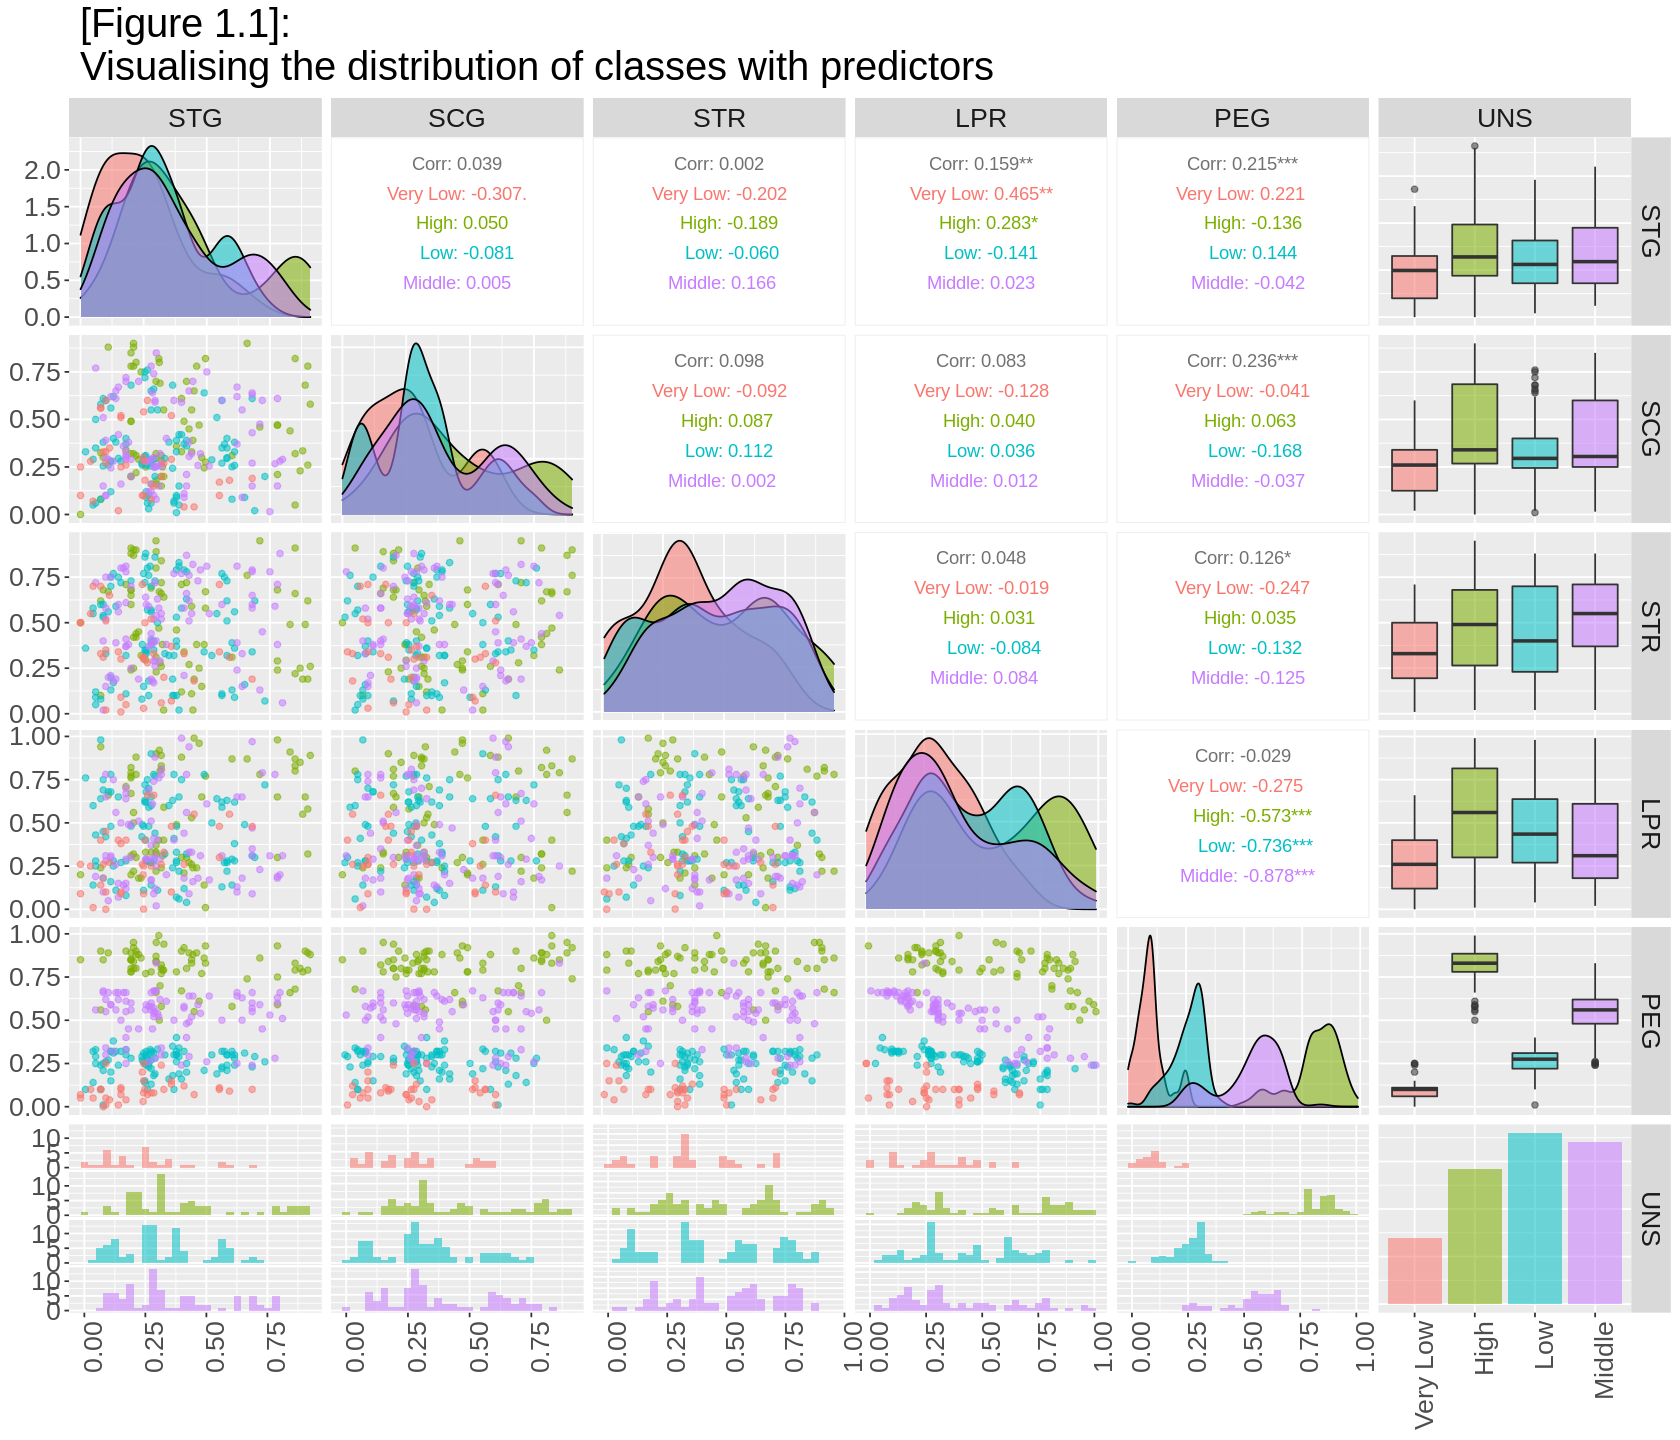

In [11]:
options(repr.plot.width = 14, repr.plot.height = 12)

#Since we have 5 predictor variables, we use ggpairs() to visualise the relationship between our classes and the predictor variables
paired_plot <- user_knowledge_training |>
               ggpairs(aes(color = UNS , alpha = 0.4))+ #colouring the data points by the UNS column (which conatins the classes to be predicted)
               ggtitle(" [Figure 1.1]: \n Visualising the distribution of classes with predictors") +
               theme(text = element_text(size = 20)) +
               theme(axis.text.x = element_text(angle = 90, hjust = 1))# adjusting the x-axis labels so they don't overlap wiht each other and are clearly visible

paired_plot

* First, from the density plots, we can observe that the density plot of the predictor **PEG** has excellent separation between each UNS class. All the colors were visible and distinguishable, with some space separating each peak of a density plot. The other density plots overlapped a lot, making it difficult to differentiate the different classes. This shows that **PEG** could be a strong predictor to use in our classification model

* From the boxplots, we found that the means in the **LPR** graph and the **PEG** graph are far from each other, which means that **LPR** and **PEG** are potential predictors for UNS. Furthermore, in the boxplot of **PEG**, even the upper and lower quantiles of the four levels of UNS are very different, which means that **PEG** could be a strong predictor. The other boxplots show that the other predictors do not effectively display the different knowledge levels since the four means and interquartile ranges overlap.

* The scatterplots hardly provide us with important information to choose predictors since no trends can be observed.
 
* From the observation above, we can conclude **PEG** is an excellent predictor for our classifier. However, we decided that choosing only one predictor may lead to some variability in prediction (as it usually happens when a model is rooted in merely one predictor). We decided to use forward selection to check whether **LPR** or other predictors can be used to build our classifier.

## Predictor variables selection 


* We begin our data analysis by tuning our classifier to choose which variables from our data will be treated as predictor variables. 
* Next, we want to determine if any irrelevant predictors in our data set will negatively impact our classifier.
* To ensure that the choice of which variables to include as predictors is part of tuning our classifier, we conduct this on our **training set**.
* We will use the forward selection method to find the best predictors.

In forward selection, we need to
1. start with a model having no predictors
2. run the following three steps until you run out of predictors:

    A.  for each unused predictor, add it to the model to form a candidate model
    
    B. tune all of the candidate models
    
    C. update the model to be the candidate model with the highest cross-validation accuracy
3. select the model that provides the best trade-off between accuracy and simplicity
    
    

In [12]:
set.seed(1) # Used to make the predictors selection reproducible


uk_subset1 <- user_knowledge_training |> select(STG,SCG,STR,LPR,PEG,UNS )
names1 <- colnames(uk_subset1 |> select(-UNS))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), model_string = character(), accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
uk_vfold <- vfold_cv(uk_subset1, v = 5, strata = UNS)

# store the total number of predictors
n_total <- length(names1)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names1)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names1[[j]])
        model_string <- paste("UNS", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        uk_recipe <- recipe(as.formula(model_string), data = uk_subset1) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(uk_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = uk_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% add_row(size = i, model_string = models[[jstar]], accuracy = accs[[jstar]])
    selected <- c(selected, names1[[jstar]])
    names1 <- names1[-jstar]
}



<center>Table 1.10 : Accuracy versus the number of predictors in the model</center>

| size | predictors | accuracy |
| --- | -: | --- | 
| 1 |  UNS ~ PEG| 0.8470551| 
| 2 | UNS ~ PEG+LPR|0.9501880| 
| 3 | UNS ~ PEG+LPR+STR |0.9431704| 
| 4 |  UNS ~ PEG+LPR+STR+STG| 0.8897243|
| 5 |  UNS ~ PEG+LPR+STR+STG+SCG| 0.8327068|



* Table 1.10 represents the models' respective accuracies for **ALL** predictor variables.
* As meaningful predictors are added, the estimated accuracy increases substantially, whereas adding irrelevant variables causes the accuracy to either exhibit small fluctuations or decrease as the model attempts to tune the number of neighbors to account for the extra noise.
* Naturally, we balance high accuracy with simplicity. Keeping this in mind, we find the best model by observing the point where the accuracy stops increasing dramatically and levels off or begins to decrease. Therefore, we chose **LPR** and **PEG** as our predictors since the accuracy decreases as we add more predictors to the model.

### Tuning our K-NN classifier

* We now conduct the K-NN classification analysis on our  dataset with predictors: **LPR** and **PEG**
* To do this, we:
1. create a recipe with the predictors:**LPR** and **PEG**, specifying the data to be **user_knowledge_training**. Additionally, we did not center or scale our predictors since they were all already in the range of 0.0 to 1.0. When scaling is performed, the value/meaning behind the data is lost. So not scaling this data would be best.
2. Define the specification for our K-NN model. We use `tune()` for the neighbors' argument because we will first tune our model to choose the best k-value for our model.
3. Perform cross-validation with five folds. This is because our dataset is a manageable size, so 20% of the data for validation is considerably accurate.
4. Create a workflow adding the recipe and the model and applying the `tune_grid()` function for cross-validation. We then collect the resulting accuracies with the `collect_metrics()` function.
5. Finally, we plot the accuracies against the neighbors to visualize the most stable k nearest neighbor.

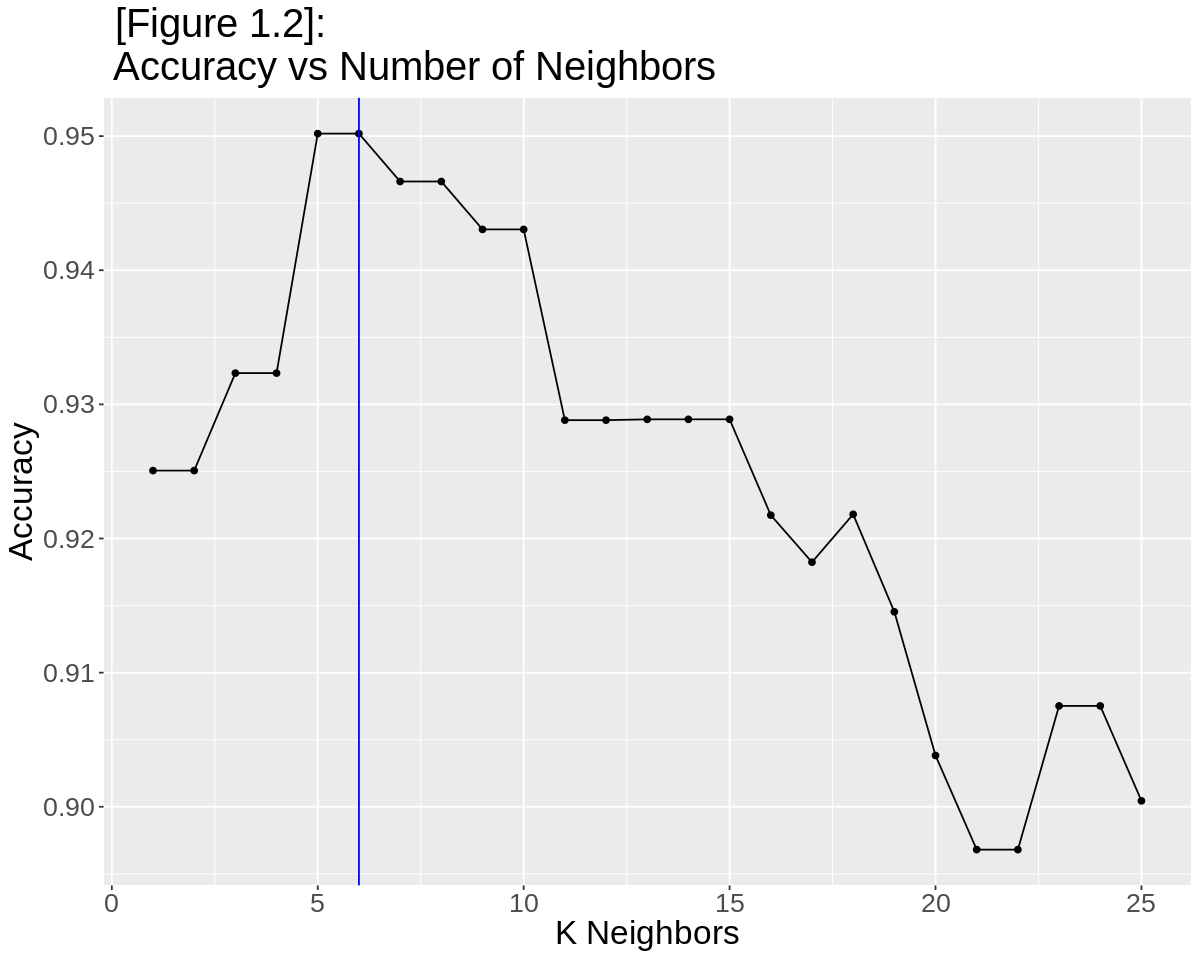

In [13]:
set.seed (1) 
options(repr.plot.height = 8, repr.plot.width = 10)

#Making the recipe with our predictor variables (LPR and PEG)
user_recipe <- recipe(UNS ~ LPR + PEG , user_knowledge_training)
               

#Making the model using "straight-line" distance between points
#We keep the number of neighbors as tune() in order to get the optimised k value usign cross-validation
user_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
              set_engine("kknn") |>
              set_mode("classification")

#We use 5 folds for cross-validation as we beilieve that it would not require a lot of time
user_vfold <- vfold_cv(user_knowledge_training, v = 5, strata = UNS)

#We test 25 values of k
klots <-  tibble(neighbors = seq(from = 1, to = 25, by = 1))

#We put it all together in a workflow
user_metrics <- workflow() |>
                add_recipe(user_recipe) |> #adding the recipe
                add_model(user_model) |> #adding the model
                tune_grid(resamples = user_vfold, grid = klots) |> #using tune_grid as we use cross-validation
                collect_metrics() #collecting the metrics of our cross validation

#Using the metric fucntion to find the accuracy of our classifier
user_accuracy <- user_metrics |> 
                 filter(.metric == "accuracy") #Filtering the column by "accuracy"

#Plotting the k values (number of neighbors) and the corresponding accuracy to get an optimized k value
cross_val_plot <- ggplot(user_accuracy, aes(x = neighbors, y = mean)) + 
                  geom_point() +
                  geom_line() +
                  geom_vline(xintercept = 6, colour = "blue")+
                  labs(x = "K Neighbors", y = "Accuracy") +
                  ggtitle(" [Figure 1.2]:\n Accuracy vs Number of Neighbors") +
                  theme(text = element_text(size = 20))
                     


cross_val_plot


* The above graph (Figure 1.2) demonstrates that **k = 6** is the most optimal value. This is because it's accuracy is relatively higher than most other neighbors and does not immediately fall as we increase or decrease the neighbor by 1

###  The K-NN Classification model

* Now, we use the number of neighbors as 6 to build our model and keep the recipe as before, as we still want to use the same two predictors. 
* We put it together in a workflow and then fit it into our **training dataset**.

In [14]:
#Now that we know that k = 6 has the highest probability of being the highest accuracy classifier, we can make the model
user_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
             set_engine("kknn") |>
             set_mode("classification")

user_fit <-  workflow() |>
             add_recipe(user_recipe) |> #adding the recipe to the workflow
             add_model(user_spec) |> #adding the model to the workflow
             fit(data = user_knowledge_training) #fitting the workflow to our training data

user_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(6,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.05338078
Best kernel: rectangular
Best k: 6

### Testing the accuracy of our K-NN classification model

* Now, we conduct  K-NN classification on the **testing set** with the help of our trained model.
* We use the `predict` function to predict the classes of the **testing set** and `bind_cols` to join the UNS class of the testing set to our predicted column to compare the two.


In [15]:
#Now that we have the model set up, we can predict the UNS class
user_predictions <- predict(user_fit, user_knowledge_test) |> 
                     bind_cols(user_knowledge_test) #adding the test data columns to our predicted column in order to see our classifier accuracy

#We use the metrics functions on the table which contains the predicted column along with the actual column to see our classsifier accuracy
user_metrics <- user_predictions |>
                metrics(truth = UNS, estimate = .pred_class) |>
                select(.metric, .estimate) |> 
                head(1)


<center>Table 1.11 : Accuracy of classifier</center>

| .metric | .estimate |
| --- | --- | 
| accuracy | 0.9918033 |

* It is observed in table 1.11 that the accuracy of our predictions was extremely high at **99.2%.**

 * To further analyse the classifier accuracy, we used `conf_mat` to make a confusion matrix. It helped us to see which observations had been predicted wrong and what were the correct classes of those observations.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



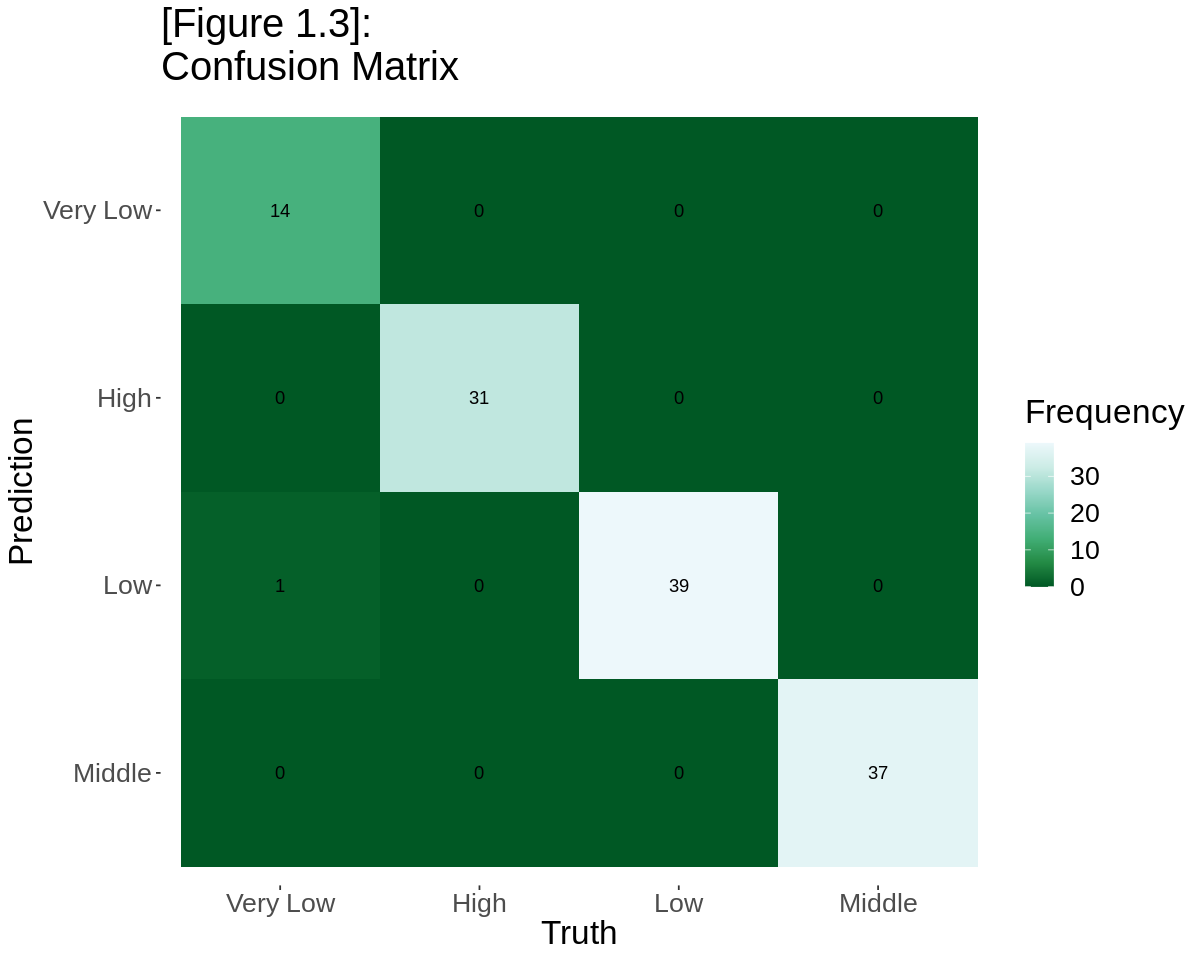

In [16]:
#We make a confusion matrix to see which classes in particular have been predicted incorrectly and whether we can afford these errors (false negatives and/or postitives) or not
user_conf <- user_predictions |>
             conf_mat(truth = UNS, estimate = .pred_class)


autoplot(user_conf, type = "heatmap") +
    scale_fill_distiller(palette = "BuGn", name = "Frequency") + #color blind friendly
    labs(title = "[Figure 1.3]: \nConfusion Matrix") +
    theme(legend.position = "right", text = element_text(size = 20))
        



* The confusion matrix (Figure 1.3) shows that our classifier has perfect accuracy for predicting *High* ,*Middle* and *Low* knowledge level. 
* Our classifier did only wrong prediction . The classifier predicted *“Low”* when the actual value was *‘Very Low’*.
* This error is not enormous since it is only one level up from what it was supposed to be
* This demonstrates that our model is working very well and its only error can be fixed easily.

* Finally, we make an interference plot to visualize our classifier's accuracy by shading the graph's area with the color of the predicted class and coloring the data points with their correct category. This way, we can visually see which data points lie in the accurate shaded color (predicted correctly) and which do not (mispredicted).

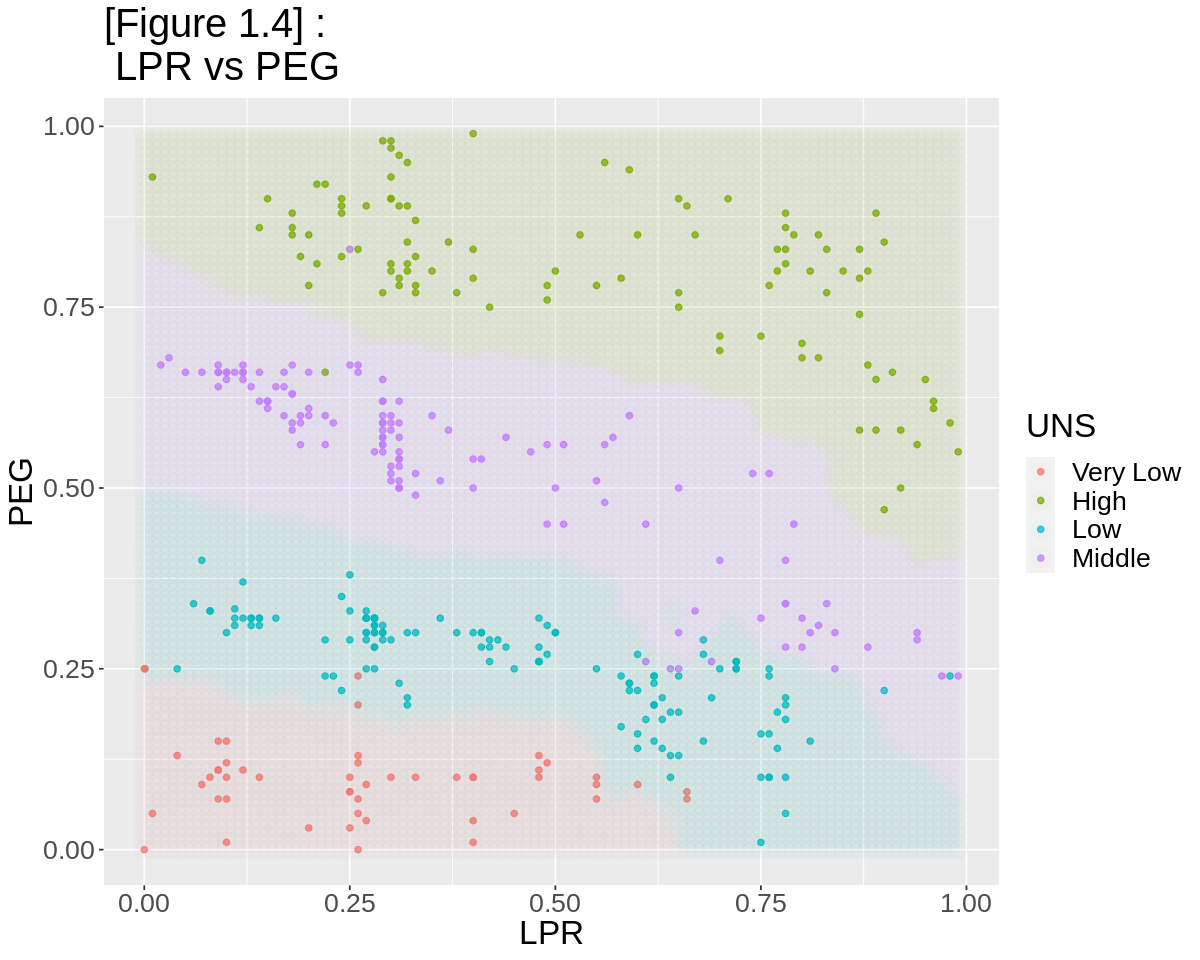

In [17]:
#Making a final plot of our classsifer which colours our classifier predictions by area

# create the grid of LPR/PEG vals, and arrange in a data frame
are_grid <- seq(min(User_Knowledge$LPR), 
                max(User_Knowledge$LPR), 
                length.out = 100)
smo_grid <- seq(min(User_Knowledge$PEG), 
                max(User_Knowledge$PEG), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(LPR = are_grid, 
                                PEG = smo_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(user_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>% 
                    rename(Class = .pred_class)

#making the decided plot
plot <- ggplot() +
              geom_point(data = User_Knowledge, 
              mapping = aes(x = LPR, 
                            y = PEG,
                            color = UNS), 
              alpha = 0.75) +
              geom_point(data = prediction_table, 
              mapping = aes(x = LPR, 
                            y = PEG,
                            color = Class), 
              alpha = 0.02, 
              size = 5) +
              labs(color = "UNS", 
              x = "LPR", 
              y = "PEG")+
               ggtitle("[Figure 1.4] : \n LPR vs PEG") +
              theme(text = element_text(size = 20))

plot

**LPR**: exam performance of the user for related objects with the goal object <br>
**PEG**: exam performance of user for goal objects <br>

**Plot Color** <br>
**Red** -Very Low User Knowledge Level <br>
**Light Blue** - Low User Knowledge Level <br>
**Light Purple**-Middle User Knowledge Level <br> 
**Green** - High User Knowledge Level<br>


* In the final plot (Figure 1.4), LPR is on the x-axis and PEG is on the y-axis. The predicted distributions of **UNS** (User knowledge Level) is also demonstrated in the plot. **PEG** and **LPR** reflect students' exam performance. The main difference between PEG and LPR is whether students must study for another exam in which the tested material is related to the main objective.

* From the plot, we observe that a few points lie outside their right color (the correct predicted color). These points are very tricky to predict since they are found closer to another knowledge level. These points reflect that the model still predicts the points well despite being located outside their region color. Thus we can responsibly say that our model is reliable. This also further emphasizes the excellent quality of our classifier. We also observe that as the values of both our predictor variables increases, the level of UNS class also increases (*Very Low* < *Low* < *Middle* < *High*)


## Discussion ##
* As evident through our analysis above, our model has shown that the best predictor variables of User Knowledge are PEG (exam performance of user for goal objects ) and  LPR (exam performance of user for related objects with goal object) – racking a 99.18% accuracy level as shown in Table 1.11. The confusion matrix (Figure 1.3) shows that we only got one prediction wrong. Overall, the matrix does not show significant false positives or negatives. From the final plot(Figure 1.4), we can observe that our classifier can still excellently predict the correct class even if they are found in other regions. Thus, we believe that the accuracy of our classifier is accurate to make any future predictions. <br>

* We expected that the higher the scores across all factors, the higher the overall knowledge. The final plot (Figure 1.3) visualizes all the predictions, and it shows the positive relationship between exam performance (LPR & PEG)  and user knowledge level (UNS). This matches our expectations, as the better the exam performance of students, the higher the overall knowledge. 

* These findings could be used to disprove the notion that test scores do not accurately reflect the user's knowledge level. Our analysis shows that higher test scores almost always correlate with a higher knowledge level. The ggpairs plot (Figure 1.1) allowed us to examine how each variable relates to one another carefully. We found that the study time and the number of repetitions do not affect exam performance. This study also shows that some students require less study time and repetition while others require more to obtain the same test result and knowledge level.

**Some future questions this could lead to is:**

1. Some students require lower study time and repetition levels, while others require more to obtain the same test result and knowledge level. If this is the case, do both groups have the same knowledge level? Are there better ways to evaluate overall knowledge?
2. How can we combine our analysis with other metrics used to test intelligence to develop a more effective and reliable system that can determine people's knowledge levels?
3. With work experience/personal projects becoming more relevant than school grades nowadays, how can we add new variables to better predict the knowledge of the students?


### Reference

1. Hamdi Tolga Kahraman, UCI Machine Learning Repository: User Knowledge Modeling Data Set (2009)  https://archive.ics.uci.edu/ml/datasets/User%2BKnowledge%2BModeling
2. Hartwig, Marissa K., et al. “General Knowledge Monitoring as a Predictor of In-class Exam Performance.” British Journal of Educational Psychology, vol. 82, no. 3, Wiley, June 2011, pp. 456–68. https://doi.org/10.1111/j.2044-8279.2011.02038.x..
3. Timbers, Tiffany Trevor Campbell. Data Science. 24 Sept. 2022,  datasciencebook.ca/index.html.

